In [1]:
# packages to import

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from fastai import *
from fastai.vision import * 
from torchvision.models import *

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score


from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

from sklearn.model_selection import KFold
from sklearn.metrics import r2_score


from imblearn.over_sampling import SMOTE

from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier

from scipy import stats
from scipy.stats import skew

import nltk
from gensim import corpora, models, matutils
nltk.download('stopwords')
from nltk.corpus import stopwords
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer


import urllib, requests, re
from time import sleep

pd.set_option('max_colwidth',500)


/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/hilmijohari/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/hilmijohari/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
# loading the csv files into pandas dataframes

df_train_mass = pd.read_csv('mass_case_description_train_set.csv')
df_test_mass = pd.read_csv('mass_case_description_test_set.csv')

df_train_calc = pd.read_csv('calc_case_description_train_set.csv')
df_test_calc = pd.read_csv('calc_case_description_test_set.csv')

test_labels_multi = pd.read_csv('./input/test_labels_multi_2.csv')
train_labels_multi = pd.read_csv('./input/train_labels_multi.csv')

In [3]:
# remove the useless columns

df_train_calc.drop(columns = ['image file path',
       'cropped image file path', 'ROI mask file path','patient_id', 'image view', 'abnormality id','abnormality type','left or right breast'], inplace = True)
df_test_calc.drop(columns = ['image file path',
       'cropped image file path', 'ROI mask file path','patient_id', 'image view', 'abnormality id','abnormality type', 'left or right breast'], inplace = True)


In [4]:
labels = pd.concat([train_labels_multi, test_labels_multi])

In [5]:
labels.reset_index(drop = True, inplace = True)

In [6]:
train_df = pd.concat([df_train_calc,df_test_calc])

train_df['pathology'].replace('MALIGNANT', 1, inplace = True)
train_df['pathology'].replace('BENIGN_WITHOUT_CALLBACK', 0, inplace = True)
train_df['pathology'].replace('BENIGN', 0, inplace = True)
train_df = train_df.dropna(axis = 0)


In [7]:
train_df.reset_index(drop = True, inplace = True)

In [8]:
train_df.columns

Index(['breast density', 'calc type', 'calc distribution', 'assessment',
       'pathology', 'subtlety'],
      dtype='object')

In [9]:
train_df['labels'] = labels['label']

In [10]:
train_df.groupby('pathology')['labels'].value_counts()

pathology  labels   
0          macro        201
           amorphous    190
           micro        185
           vascular     163
1          micro        191
           vascular     168
           amorphous    161
           macro        150
Name: labels, dtype: int64

In [11]:
train_df.columns

Index(['breast density', 'calc type', 'calc distribution', 'assessment',
       'pathology', 'subtlety', 'labels'],
      dtype='object')

In [13]:
train_df['text'] = train_df[['calc type', 'calc distribution']].apply(lambda x: ' '.join(x), axis=1)

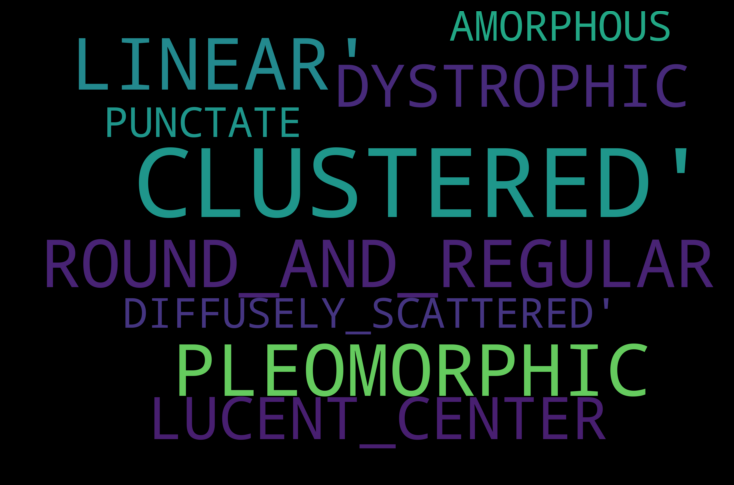

In [15]:
text = train_df[train_df['pathology'] == 0]['text'].values
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'black',
    stopwords = STOPWORDS).generate(str(text))
fig = plt.figure(
    figsize = (10, 10),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

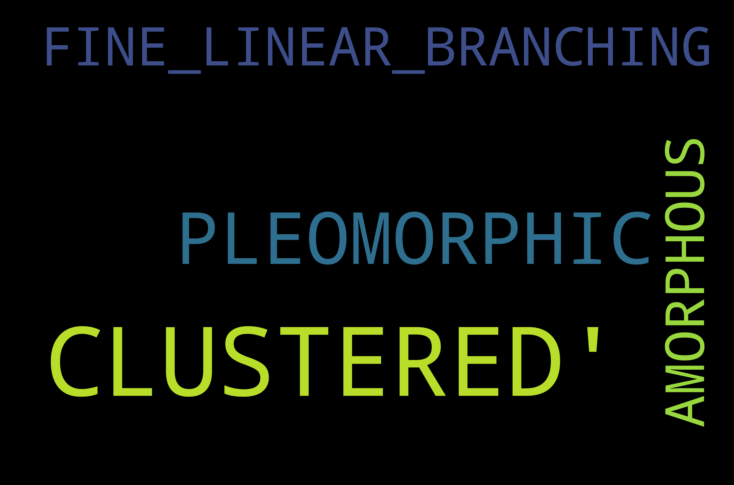

In [16]:
text = train_df[train_df['pathology'] == 1]['text'].values
wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'black',
    stopwords = STOPWORDS).generate(str(text))
fig = plt.figure(
    figsize = (10, 10),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

In [20]:
train_df.drop(columns = ['text'],inplace = True)

In [21]:
def cleaning_df(dataframe):
    
    for column_name in ['calc distribution', 'calc type']:

        dataframe[column_name] = dataframe[column_name].apply(lambda x : x.lower())
        
        dataframe[column_name] =  dataframe[column_name].apply(lambda x : re.sub(r'[^a-zA-Z]', " ", x))

cleaning_df(train_df)

In [22]:
train_df.reset_index(inplace = True, drop =True)

In [23]:
dums = pd.get_dummies(train_df['labels'], drop_first = True)
dums.reset_index(drop = True, inplace = True)

In [24]:
characters_to_replace = ['assessment']

stop_words = stopwords.words('english')
stop_words += characters_to_replace

In [25]:
vect_1 = CountVectorizer(stop_words = stop_words, min_df = 1, ngram_range = (1,3))
d_vector = vect_1.fit_transform(train_df['calc distribution'])
d_trans = pd.DataFrame(d_vector.todense(),columns=vect_1.get_feature_names())
d_trans.reset_index(inplace = True, drop =True)
train_df_2 = pd.concat([train_df, d_trans, dums], axis = 1)

In [26]:
vect_1 = CountVectorizer(stop_words = stop_words, min_df = 1, ngram_range = (1,3))
d_vector = vect_1.fit_transform(train_df['calc type'])
d_trans = pd.DataFrame(d_vector.todense(),columns=vect_1.get_feature_names())
d_trans.reset_index(inplace = True, drop =True)
train_df_3 = pd.concat([train_df_2, d_trans], axis = 1)

In [27]:
train_df_3.drop(columns = ['calc distribution', 'calc type', 'labels'], inplace = True)

In [28]:
d = train_df_3[['pathology', 'assessment']]

/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


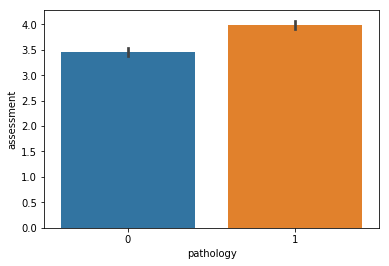

In [29]:
import seaborn as sns
sns.barplot(x = 'pathology', y = 'assessment', data = d)

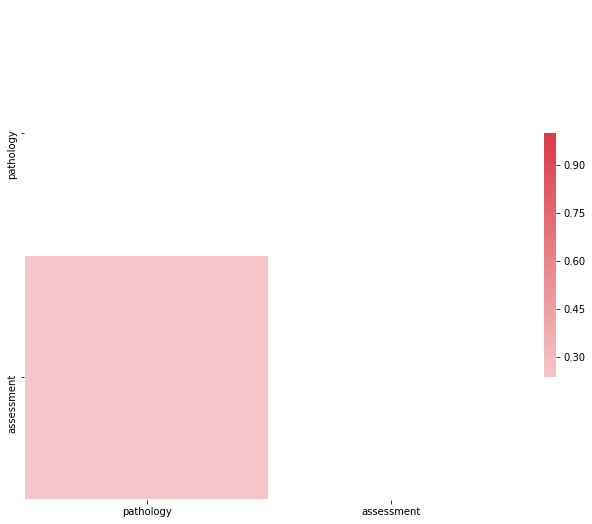

In [30]:
import seaborn as sns
# Compute the correlation matrix
corr = d.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [31]:
train_df_3['pathology'].value_counts()

0    739
1    670
Name: pathology, dtype: int64

In [32]:
train_df_3.groupby('fine')['pathology'].value_counts()

fine  pathology
0     0            718
      1            557
1     1            113
      0             21
Name: pathology, dtype: int64

In [33]:
train_df_3.columns

Index(['breast density', 'assessment', 'pathology', 'subtlety', 'clustered',
       'clustered linear', 'clustered segmental', 'diffusely',
       'diffusely scattered', 'linear', 'linear segmental', 'regional',
       'regional regional', 'scattered', 'segmental', 'macro', 'micro',
       'vascular', 'amorphous', 'amorphous pleomorphic', 'amorphous round',
       'amorphous round regular', 'branching', 'calcium', 'center',
       'center dystrophic', 'center punctate', 'center round',
       'center round regular', 'centered', 'coarse', 'coarse lucent',
       'coarse lucent center', 'coarse pleomorphic', 'dystrophic', 'eggshell',
       'fine', 'fine linear', 'fine linear branching', 'large',
       'large rodlike', 'large rodlike round', 'linear', 'linear branching',
       'lucent', 'lucent center', 'lucent center dystrophic',
       'lucent center punctate', 'lucent center round', 'lucent centered',
       'milk', 'milk calcium', 'pleomorphic', 'pleomorphic amorphous',
       'ple

In [34]:
X = train_df_3.drop(columns = ['pathology'])
y = train_df_3['pathology']

In [35]:
# Split data 90 : 10
X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, test_size = 0.1, random_state = 42)

In [36]:
def model_selection(X, y, xt, yt):
    for k in [1,2,4,6,8,10,20, 30, 40]:
        mod = KNeighborsClassifier(n_neighbors= k)
        scores = cross_val_score(mod, X,y, cv = 5, scoring = 'accuracy')
        mod = mod.fit(X,y)
        y_pred = mod.predict(xt)
        
        print('Mean accuracy :', round(np.mean(scores),2), 'Std accuracy:', round(np.std(scores),2))
        print('confusion matrix ', confusion_matrix(yt, y_pred))
        
model_selection(X_train, y_train, X_test, y_test)

Mean accuracy : 0.71 Std accuracy: 0.03
confusion matrix  [[54 18]
 [20 49]]
Mean accuracy : 0.71 Std accuracy: 0.02
confusion matrix  [[63  9]
 [39 30]]
Mean accuracy : 0.71 Std accuracy: 0.02
confusion matrix  [[62 10]
 [28 41]]
Mean accuracy : 0.72 Std accuracy: 0.01
confusion matrix  [[60 12]
 [23 46]]
Mean accuracy : 0.72 Std accuracy: 0.02
confusion matrix  [[59 13]
 [25 44]]
Mean accuracy : 0.71 Std accuracy: 0.02
confusion matrix  [[58 14]
 [25 44]]
Mean accuracy : 0.71 Std accuracy: 0.01
confusion matrix  [[59 13]
 [25 44]]
Mean accuracy : 0.7 Std accuracy: 0.0
confusion matrix  [[57 15]
 [23 46]]
Mean accuracy : 0.69 Std accuracy: 0.01
confusion matrix  [[57 15]
 [26 43]]


In [37]:
def model_selection(X, y, xt, yt):
    for c in [0.0001, 0.01, 0.1, 1, 10, 100,1000]:
        mod = LogisticRegression(C = c, solver = 'lbfgs', max_iter = 1000)
        scores = cross_val_score(mod, X,y, cv = 5, scoring = 'accuracy')
        mod = mod.fit(X,y)
        y_pred = mod.predict(xt)
        
        print('Mean accuracy :', round(np.mean(scores),2), 'Std accuracy:', round(np.std(scores),2))
        print('confusion matrix ', confusion_matrix(yt, y_pred))
        
model_selection(X_train, y_train, X_test, y_test)

Mean accuracy : 0.53 Std accuracy: 0.0
confusion matrix  [[72  0]
 [69  0]]
Mean accuracy : 0.7 Std accuracy: 0.03
confusion matrix  [[64  8]
 [38 31]]
Mean accuracy : 0.67 Std accuracy: 0.03
confusion matrix  [[58 14]
 [29 40]]
Mean accuracy : 0.67 Std accuracy: 0.04
confusion matrix  [[56 16]
 [28 41]]
Mean accuracy : 0.66 Std accuracy: 0.04
confusion matrix  [[54 18]
 [28 41]]
Mean accuracy : 0.67 Std accuracy: 0.03
confusion matrix  [[54 18]
 [28 41]]
Mean accuracy : 0.67 Std accuracy: 0.03
confusion matrix  [[53 19]
 [28 41]]


In [38]:
mod = LogisticRegression(C = .100, solver = 'lbfgs', max_iter = 1000)
mod = mod.fit(X_train, y_train)
y_pred = mod.predict(X_test)
confusion_matrix(y_test, y_pred)

array([[58, 14],
       [29, 40]])

In [39]:
## extract coefficients
values_log = pd.DataFrame(mod.coef_[0], columns = ['coefs'])
values_log['Features'] = X.columns

In [40]:
print('Top Features that dictate data job title positively')
print('------------------------------------------')
values_log.sort_values(by = 'coefs', ascending = False).head(10)

Top Features that dictate data job title positively
------------------------------------------


,coefs,Features
51,0.644515,pleomorphic
1,0.310801,assessment
21,0.300982,branching
37,0.300982,fine linear branching
41,0.300982,linear
35,0.300982,fine
42,0.300982,linear branching
36,0.300982,fine linear
8,0.291303,linear
59,0.265796,punctate fine


In [93]:

for c in [100]:
    clf = AdaBoostClassifier(base_estimator = DecisionTreeClassifier(max_depth = 20), learning_rate = 0.00001, n_estimators=c, random_state=42)
    scores = cross_val_score(clf, X_train,y_train, cv = 3, scoring = 'accuracy')
    clf = clf.fit(X_train,y_train)
    y_pred = clf.predict(X_test)
        
    print('Mean accuracy :', round(np.mean(scores),2), 'Std accuracy:', round(np.std(scores),2))
    print('confusion matrix ', confusion_matrix(y_test, y_pred))



Mean accuracy : 1.0 Std accuracy: 0.0
confusion matrix  [[ 12   2]
 [  0 127]]


In [94]:
clf.feature_importances_

array([4.081099e-02, 7.691669e-01, 3.546505e-02, 1.119951e-04, ..., 0.000000e+00, 0.000000e+00, 0.000000e+00,
       0.000000e+00])

In [95]:
## extract coefficients
values_log = pd.DataFrame(clf.feature_importances_, columns = ['feature_importances'])
values_log['Features'] = X.columns

In [96]:
print('Top Features that dictate data job title positively')
print('------------------------------------------')
values_log.sort_values(by = 'feature_importances', ascending = False).head(10)

Top Features that dictate data job title positively
------------------------------------------


,feature_importances,Features
1,0.769167,assessment
17,0.042575,amorphous
0,0.040811,breast density
2,0.035465,subtlety
6,0.016604,diffusely
7,0.015707,diffusely scattered
33,0.014406,dystrophic
12,0.012565,scattered
13,0.011330,segmental
14,0.007042,macro


In [41]:
import xgboost as xgb
from xgboost.sklearn import XGBClassifier

In [42]:
param_test1 = {
   'n_estimators' : [10,50,100,20,300,500,1000]
}

gsearch1 = GridSearchCV(estimator = XGBClassifier(learning_rate =0.1, n_estimators=300, max_depth=9,
 min_child_weight=1, gamma=0, subsample=0.9, colsample_bytree=0.9,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27, res_alpha = 1e-05), 
 param_grid = param_test1, scoring='average_precision',n_jobs=4,iid=False, cv=5)

gsearch1.fit(X_train, y_train)
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:762: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.83389, std: 0.01863, params: {'n_estimators': 10},
  mean: 0.84132, std: 0.01108, params: {'n_estimators': 50},
  mean: 0.84307, std: 0.01019, params: {'n_estimators': 100},
  mean: 0.84013, std: 0.01550, params: {'n_estimators': 20},
  mean: 0.84317, std: 0.01232, params: {'n_estimators': 300},
  mean: 0.83788, std: 0.01248, params: {'n_estimators': 500},
  mean: 0.83104, std: 0.01528, params: {'n_estimators': 1000}],
 {'n_estimators': 300},
 0.8431732032417383)

In [43]:
xgb = XGBClassifier(learning_rate =0.1, n_estimators=300, max_depth=9,
 min_child_weight=1, gamma=0, subsample=0.9, colsample_bytree=0.9,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27, res_alpha = 1e-05)

xgb = xgb.fit(X_train, y_train)

y_pred =xgb.predict(X_test)
confusion_matrix(y_test, y_pred)


/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


array([[58, 14],
       [14, 55]])

In [44]:
xgb.feature_importances_


array([0.017177, 0.09508 , 0.020413, 0.023464, ..., 0.      , 0.058486, 0.      , 0.      ], dtype=float32)

In [45]:
## extract coefficients
values_log = pd.DataFrame(xgb.feature_importances_, columns = ['feature_importances'])
values_log['Features'] = X.columns

In [46]:
print('Top Features that dictate data job title positively')
print('------------------------------------------')
values_log.sort_values(by = 'feature_importances', ascending = False).head(10)

Top Features that dictate data job title positively
------------------------------------------


,feature_importances,Features
1,0.095080,assessment
35,0.088914,fine
5,0.072438,clustered segmental
78,0.059723,round regular pleomorphic
21,0.058668,branching
66,0.058633,regular
81,0.058486,vascular
69,0.054747,regular pleomorphic
33,0.047382,dystrophic
8,0.036791,linear


In [48]:
from sklearn.metrics import precision_score
precision_score(y_test, y_pred)

0.7971014492753623